# Classyfing the contributions

Based on the assumption, that certain keywords are linked to specific classes of contribution, this notebook aimes to use Machine Learning to assign a contribution class to the description of the contribution which can be found within the documents and in the future should be extracted with the help of Fonduer.

The following dataset was created manually by the Labelteam and transformed by Thorben for the purpose of ML. Every contribution is linked to a class_label.

In [1]:
import pandas as pd

data = pd.read_excel("./labeled_contribution_samples_2.xlsx")

data

,contribution,class_label
0,conceptualised experiments,Conceptualization / Conceptualisation
1,conceptualised project,Conceptualization / Conceptualisation
2,conceptualised task,Conceptualization / Conceptualisation
3,conceptualized experiments,Conceptualization / Conceptualisation
4,conceptualized project,Conceptualization / Conceptualisation
...,...,...
444,Created a custom jewelry piece,Other - not related
445,Started a podcast on a topic you love,Other - not related
446,Designed a new board game,Other - not related
447,Wrote a guidebook for your city,Other - not related


In [2]:
import numpy as np
label_dict = dict(enumerate(np.sort(data.class_label.unique()).flatten(),0))

There are 17 class labels available:

In [3]:
label_dict

{0: 'Conceptualization / Conceptualisation',
 1: 'Data curation',
 2: 'Formal analysis',
 3: 'Funding acquisition',
 4: 'Investigation',
 5: 'Methodology',
 6: 'Other - not related',
 7: 'Project administration',
 8: 'Resources',
 9: 'Software',
 10: 'Sonstiges',
 11: 'Supervision',
 12: 'Support',
 13: 'Validation',
 14: 'Visualization / Visualisation',
 15: 'Writing - original draft',
 16: 'Writing - review & editing'}

Assign a code to the respective class_labels

In [4]:
label_df = pd.DataFrame.from_dict(label_dict, orient = 'index', columns = ['class_label']).reset_index(names = 'label_code')

In [5]:
contributions_df = data.merge(label_df)

Shuffle the dataset.

In [6]:
contributions_df_shuffled = contributions_df.sample(frac=1).reset_index(drop=True)
contributions_df_shuffled

,contribution,class_label,label_code
0,"assisted with NOD mice experiments, NOD mice c...",Sonstiges,10
1,had full access to the data,Sonstiges,10
2,selected drug targets,Project administration,7
3,Painted a landscape picture,Other - not related,6
4,were responsible for conceptualization,Conceptualization / Conceptualisation,0
...,...,...,...
444,for critical discussion on constructing iBKH,Investigation,4
445,provided useful suggestions for the evaluation,Resources,8
446,approved final version to be published,Supervision,11
447,carried out analysis,Formal analysis,2


Hot encoding of words in contribution

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer

contributions_list = contributions_df_shuffled["contribution"].to_list()

# create a tokenizer, configured to only take the top N=1000 most common words
tokenizer = Tokenizer(num_words=1000)
# this builds the word index
tokenizer.fit_on_texts(contributions_list)

# this turns strings into lists of integer indices
sequences = tokenizer.texts_to_sequences(contributions_list)

# directly get the one-hot binary representation
one_hot_results = tokenizer.texts_to_matrix(contributions_list, mode='binary') 

# recover the word index that was computed
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 640 unique tokens.


Create datasets for training, validating and testing. 
  
70 % / 20 % / 10 %

In [8]:
from tensorflow.keras.utils import to_categorical

# where to slice the dataset:
train_size = int(round(0.7 * contributions_df_shuffled.shape[0],0))
val_size = int(round(0.2 * contributions_df_shuffled.shape[0],0))
test_size = int(round(0.1 * contributions_df_shuffled.shape[0],0))

# slice data
train_data = one_hot_results[:train_size]
val_data = one_hot_results[train_size:train_size + val_size]
test_data = one_hot_results[train_size+val_size:]

# slice labels
train_labels = to_categorical(contributions_df_shuffled.label_code)[:train_size]
val_labels = to_categorical(contributions_df_shuffled.label_code)[train_size:train_size + val_size]
test_labels = to_categorical(contributions_df_shuffled.label_code)[train_size+val_size:]

In [9]:
len(train_labels[0])

17

### Simple ANN model


Building a first really simple model

Regarding the metrics, taken from ChatGPT:

```When dealing with an unbalanced multi-class classification problem, it is important to choose appropriate loss functions and evaluation metrics that can handle the class imbalance effectively. Here are some commonly used options:

Loss Functions:

Cross-Entropy Loss: Cross-entropy loss is widely used for multi-class classification tasks. It calculates the loss between the predicted probabilities and the true class labels. You can use the standard cross-entropy loss function for your neural network.

Weighted Cross-Entropy Loss: This variation of cross-entropy loss assigns different weights to each class to account for the class imbalance. It gives higher weight to underrepresented classes, thereby increasing their impact on the overall loss calculation. Weighted cross-entropy loss can help in addressing the class imbalance issue.

Focal Loss: Focal loss is specifically designed to handle class imbalance by downweighting the well-classified examples. It assigns higher weights to misclassified examples, especially for the minority classes. Focal loss can help the model focus more on the challenging examples and improve performance on the minority classes.

Metrics:

Accuracy: Accuracy is a commonly used metric for evaluating classification models. However, it may not be the most suitable metric for unbalanced datasets since it can be misleading when the majority class dominates the dataset. It can provide an inflated view of the model's performance.

Precision, Recall, and F1-Score: Precision measures the proportion of correctly predicted positive instances out of all predicted positive instances, while recall measures the proportion of correctly predicted positive instances out of all actual positive instances. F1-score is the harmonic mean of precision and recall, providing a balanced evaluation metric. These metrics are especially useful for imbalanced datasets as they focus on the performance of individual classes.

Area Under the Receiver Operating Characteristic Curve (AUC-ROC): AUC-ROC is a popular metric that evaluates the model's ability to distinguish between different classes. It considers the trade-off between true positive rate (sensitivity) and false positive rate (1-specificity) across different probability thresholds. AUC-ROC is advantageous for imbalanced datasets as it provides an aggregate performance measure across all classes.

It is worth noting that the choice of loss function and metric may vary depending on the specific characteristics of your dataset and the objectives of your project. It is recommended to experiment with different options and choose the ones that best align with your goals.
```

In [10]:
# Source: https://saturncloud.io/blog/custom-f1score-metric-in-tensorflow/
from tensorflow.keras import backend as K

def custom_f1_score(y_true, y_pred):
    # Define the true positives, false positives and false negatives
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    # Calculate the precision and recall
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    # Calculate the F1 score
    f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    return f1_score

In [11]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import metrics

model = models.Sequential()

model.add(layers.Dense(64, activation='relu', input_shape=(1000,)))
model.add(layers.Dense(64, activation='relu', input_shape=(1000,)))
model.add(layers.Dense(17, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=[custom_f1_score])

Training the ANN for 20 epochs with batch_size=64 and use the history object.

In [12]:
history = model.fit(train_data,
                    train_labels,
                    epochs=20,
                    batch_size=64,
                    validation_data=(val_data, val_labels))

Epoch 1/20
5/5 [==============================] - 2s 116ms/step - loss: 2.8081 - custom_f1_score: 0.0000e+00 - val_loss: 2.7876 - val_custom_f1_score: 0.0000e+00
Epoch 2/20
5/5 [==============================] - 0s 17ms/step - loss: 2.7286 - custom_f1_score: 0.0000e+00 - val_loss: 2.7422 - val_custom_f1_score: 0.0000e+00
Epoch 3/20
5/5 [==============================] - 0s 17ms/step - loss: 2.6477 - custom_f1_score: 0.0000e+00 - val_loss: 2.6867 - val_custom_f1_score: 0.0000e+00
Epoch 4/20
5/5 [==============================] - 0s 16ms/step - loss: 2.5562 - custom_f1_score: 0.0000e+00 - val_loss: 2.6248 - val_custom_f1_score: 0.0000e+00
Epoch 5/20
5/5 [==============================] - 0s 17ms/step - loss: 2.4559 - custom_f1_score: 0.0000e+00 - val_loss: 2.5586 - val_custom_f1_score: 0.0000e+00
Epoch 6/20
5/5 [==============================] - 0s 16ms/step - loss: 2.3444 - custom_f1_score: 0.0000e+00 - val_loss: 2.4892 - val_custom_f1_score: 0.0000e+00
Epoch 7/20
5/5 [=================

In [13]:
history.history.keys()

dict_keys(['loss', 'custom_f1_score', 'val_loss', 'val_custom_f1_score'])

Visualize the loss and accuracy by using pyplot.

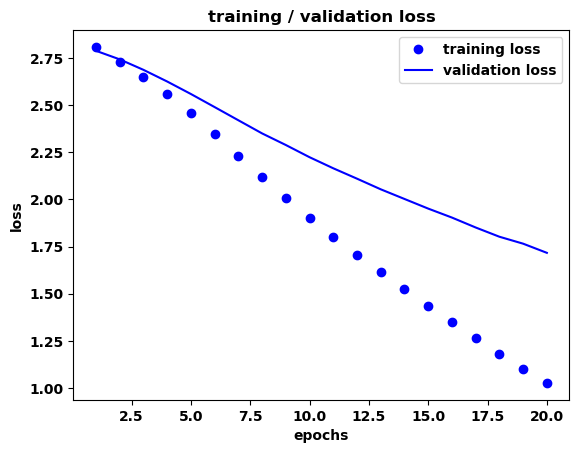

In [14]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training / validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

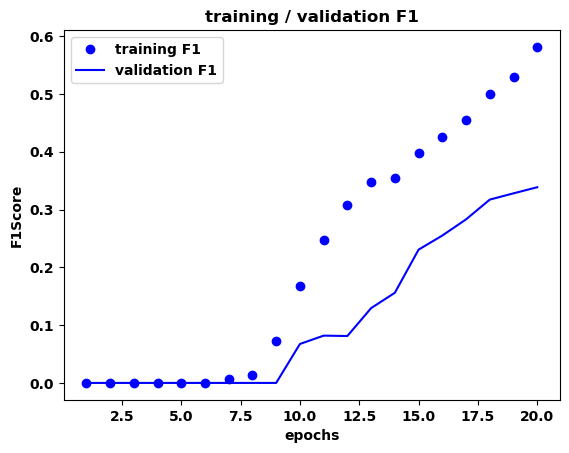

In [15]:
plt.clf()

acc = history.history['custom_f1_score']
val_acc = history.history['val_custom_f1_score']

plt.plot(epochs, acc, 'bo', label='training F1')
plt.plot(epochs, val_acc, 'b', label='validation F1')
plt.title('training / validation F1')
plt.xlabel('epochs')
plt.ylabel('F1Score')
plt.legend()

plt.show()

In [16]:
results = model.evaluate(test_data, test_labels)

2/2 [==============================] - 0s 5ms/step - loss: 1.6285 - custom_f1_score: 0.3041


In [17]:
results

[1.6285182237625122, 0.3040650188922882]

The performance of this really simple model is not great, with an F1 score of 49,6 % for the test data. Lets add some parameter testing.

In [18]:
test_plan = {}
test_plan[0] = {"n_units": 32, "n_hidden_layers": 1, "n_epochs": 20, "n_batch_size": 64}
test_plan[1] = {"n_units": 32, "n_hidden_layers": 2, "n_epochs": 20, "n_batch_size": 64}
test_plan[2] = {"n_units": 32, "n_hidden_layers": 3, "n_epochs": 20, "n_batch_size": 64}
test_plan[3] = {"n_units": 64, "n_hidden_layers": 1, "n_epochs": 20, "n_batch_size": 64}
test_plan[4] = {"n_units": 64, "n_hidden_layers": 2, "n_epochs": 20, "n_batch_size": 64}
test_plan[5] = {"n_units": 64, "n_hidden_layers": 3, "n_epochs": 20, "n_batch_size": 64}
test_plan[6] = {"n_units": 128, "n_hidden_layers": 1, "n_epochs": 20, "n_batch_size": 64}
test_plan[7] = {"n_units": 128, "n_hidden_layers": 2, "n_epochs": 20, "n_batch_size": 64}
test_plan[8] = {"n_units": 128, "n_hidden_layers": 3, "n_epochs": 20, "n_batch_size": 64}
test_plan[9] = {"n_units": 64, "n_hidden_layers": 2, "n_epochs": 50, "n_batch_size": 64}
test_plan[10] = {"n_units": 64, "n_hidden_layers": 2, "n_epochs": 100, "n_batch_size": 64}
test_plan[11] = {"n_units": 64, "n_hidden_layers": 2, "n_epochs": 20, "n_batch_size": 32}
test_plan[12] = {"n_units": 64, "n_hidden_layers": 2, "n_epochs": 20, "n_batch_size": 16}
test_plan[13] = {"n_units": 64, "n_hidden_layers": 2, "n_epochs": 20, "n_batch_size": 128}
test_plan[14] = {"n_units": 64, "n_hidden_layers": 2, "n_epochs": 100, "n_batch_size": 16}
test_plan[15] = {"n_units": 64, "n_hidden_layers": 2, "n_epochs": 150, "n_batch_size": 16}
test_plan[16] = {"n_units": 64, "n_hidden_layers": 2, "n_epochs": 200, "n_batch_size": 16}

In [19]:
result_dict = {}

for n in range(len(test_plan)):
    units = test_plan[n]["n_units"]
    hidden_layers = test_plan[n]["n_hidden_layers"]
    n_epochs = test_plan[n]["n_epochs"]
    n_batch_size = test_plan[n]["n_batch_size"]
    
    #initiate model
    model = models.Sequential()
    
    #add hidden layers
    if hidden_layers == 1:
        model.add(layers.Dense(units, activation='relu', input_shape=(1000,)))
    else:
        for i in range(hidden_layers):
            model.add(layers.Dense(units, activation='relu', input_shape=(1000,)))

    # add output layer
    model.add(layers.Dense(17, activation='softmax'))

    #compile model
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=[custom_f1_score])

    #fit model
    model.fit(train_data,
              train_labels,
              epochs=n_epochs,
              batch_size=n_batch_size,
              validation_data=(val_data, val_labels))

    results = model.evaluate(test_data, test_labels)
                               
    result_dict[n] = {"activation": "relu/softmax",  
                     "n_units": units, 
                     "n_hidden_layers": hidden_layers, 
                     "n_epochs": n_epochs,
                     "n_batch_size": n_batch_size,
                     "optimizer": "rmsprop", 
                     "loss": "categorical_crossentropy",
                     "F1 Score": results[1]}

Epoch 1/20
5/5 [==============================] - 1s 84ms/step - loss: 2.8147 - custom_f1_score: 0.0000e+00 - val_loss: 2.7956 - val_custom_f1_score: 0.0000e+00
Epoch 2/20
5/5 [==============================] - 0s 14ms/step - loss: 2.7583 - custom_f1_score: 0.0000e+00 - val_loss: 2.7736 - val_custom_f1_score: 0.0000e+00
Epoch 3/20
5/5 [==============================] - 0s 13ms/step - loss: 2.7150 - custom_f1_score: 0.0000e+00 - val_loss: 2.7534 - val_custom_f1_score: 0.0000e+00
Epoch 4/20
5/5 [==============================] - 0s 13ms/step - loss: 2.6733 - custom_f1_score: 0.0000e+00 - val_loss: 2.7325 - val_custom_f1_score: 0.0000e+00
Epoch 5/20
5/5 [==============================] - 0s 14ms/step - loss: 2.6303 - custom_f1_score: 0.0000e+00 - val_loss: 2.7108 - val_custom_f1_score: 0.0000e+00
Epoch 6/20
5/5 [==============================] - 0s 14ms/step - loss: 2.5857 - custom_f1_score: 0.0000e+00 - val_loss: 2.6880 - val_custom_f1_score: 0.0000e+00
Epoch 7/20
5/5 [==================

5/5 [==============================] - 0s 15ms/step - loss: 2.1363 - custom_f1_score: 0.0000e+00 - val_loss: 2.4703 - val_custom_f1_score: 0.0000e+00
Epoch 12/20
5/5 [==============================] - 0s 13ms/step - loss: 2.0535 - custom_f1_score: 0.0133 - val_loss: 2.4364 - val_custom_f1_score: 0.0000e+00
Epoch 13/20
5/5 [==============================] - 0s 14ms/step - loss: 1.9655 - custom_f1_score: 0.0559 - val_loss: 2.4035 - val_custom_f1_score: 0.0000e+00
Epoch 14/20
5/5 [==============================] - 0s 14ms/step - loss: 1.8854 - custom_f1_score: 0.1634 - val_loss: 2.3707 - val_custom_f1_score: 0.0000e+00
Epoch 15/20
5/5 [==============================] - 0s 14ms/step - loss: 1.8035 - custom_f1_score: 0.2066 - val_loss: 2.3460 - val_custom_f1_score: 0.0303
Epoch 16/20
5/5 [==============================] - 0s 14ms/step - loss: 1.7256 - custom_f1_score: 0.2828 - val_loss: 2.3113 - val_custom_f1_score: 0.0818
Epoch 17/20
5/5 [==============================] - 0s 14ms/step - lo

5/5 [==============================] - 0s 15ms/step - loss: 1.0148 - custom_f1_score: 0.5819 - val_loss: 1.9110 - val_custom_f1_score: 0.3363
Epoch 13/20
5/5 [==============================] - 0s 14ms/step - loss: 0.8974 - custom_f1_score: 0.6556 - val_loss: 1.8635 - val_custom_f1_score: 0.3613
Epoch 14/20
5/5 [==============================] - 0s 14ms/step - loss: 0.7923 - custom_f1_score: 0.7096 - val_loss: 1.8269 - val_custom_f1_score: 0.3811
Epoch 15/20
5/5 [==============================] - 0s 15ms/step - loss: 0.6985 - custom_f1_score: 0.7607 - val_loss: 1.7975 - val_custom_f1_score: 0.4158
Epoch 16/20
5/5 [==============================] - 0s 15ms/step - loss: 0.6161 - custom_f1_score: 0.7942 - val_loss: 1.7716 - val_custom_f1_score: 0.3953
Epoch 17/20
5/5 [==============================] - 0s 15ms/step - loss: 0.5416 - custom_f1_score: 0.8232 - val_loss: 1.7528 - val_custom_f1_score: 0.4413
Epoch 18/20
5/5 [==============================] - 0s 17ms/step - loss: 0.4769 - custom_

5/5 [==============================] - 0s 15ms/step - loss: 0.6385 - custom_f1_score: 0.7893 - val_loss: 1.8917 - val_custom_f1_score: 0.3986
Epoch 26/100
5/5 [==============================] - 0s 15ms/step - loss: 0.5893 - custom_f1_score: 0.7998 - val_loss: 1.8831 - val_custom_f1_score: 0.3963
Epoch 27/100
5/5 [==============================] - 0s 14ms/step - loss: 0.5441 - custom_f1_score: 0.8306 - val_loss: 1.8715 - val_custom_f1_score: 0.4272
Epoch 28/100
5/5 [==============================] - 0s 14ms/step - loss: 0.5026 - custom_f1_score: 0.8411 - val_loss: 1.8684 - val_custom_f1_score: 0.4595
Epoch 29/100
5/5 [==============================] - 0s 14ms/step - loss: 0.4605 - custom_f1_score: 0.8633 - val_loss: 1.8641 - val_custom_f1_score: 0.4802
Epoch 30/100
5/5 [==============================] - 0s 14ms/step - loss: 0.4259 - custom_f1_score: 0.8781 - val_loss: 1.8621 - val_custom_f1_score: 0.5046
Epoch 31/100
5/5 [==============================] - 0s 15ms/step - loss: 0.3931 - c

Epoch 78/100
5/5 [==============================] - 0s 15ms/step - loss: 0.0274 - custom_f1_score: 0.9872 - val_loss: 2.7334 - val_custom_f1_score: 0.5956
Epoch 79/100
5/5 [==============================] - 0s 15ms/step - loss: 0.0258 - custom_f1_score: 0.9809 - val_loss: 2.7488 - val_custom_f1_score: 0.5935
Epoch 80/100
5/5 [==============================] - 0s 14ms/step - loss: 0.0259 - custom_f1_score: 0.9841 - val_loss: 2.7743 - val_custom_f1_score: 0.5935
Epoch 81/100
5/5 [==============================] - 0s 14ms/step - loss: 0.0245 - custom_f1_score: 0.9828 - val_loss: 2.7952 - val_custom_f1_score: 0.5935
Epoch 82/100
5/5 [==============================] - 0s 14ms/step - loss: 0.0267 - custom_f1_score: 0.9825 - val_loss: 2.8234 - val_custom_f1_score: 0.5867
Epoch 83/100
5/5 [==============================] - 0s 14ms/step - loss: 0.0250 - custom_f1_score: 0.9837 - val_loss: 2.8535 - val_custom_f1_score: 0.5935
Epoch 84/100
5/5 [==============================] - 0s 14ms/step - los

20/20 [==============================] - 0s 5ms/step - loss: 0.2684 - custom_f1_score: 0.9201 - val_loss: 2.0041 - val_custom_f1_score: 0.5435
Epoch 21/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2340 - custom_f1_score: 0.9320 - val_loss: 2.0210 - val_custom_f1_score: 0.5292
Epoch 22/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2056 - custom_f1_score: 0.9436 - val_loss: 2.0484 - val_custom_f1_score: 0.5323
Epoch 23/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1784 - custom_f1_score: 0.9539 - val_loss: 2.1065 - val_custom_f1_score: 0.5405
Epoch 24/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1575 - custom_f1_score: 0.9590 - val_loss: 2.1452 - val_custom_f1_score: 0.5569
Epoch 25/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1413 - custom_f1_score: 0.9608 - val_loss: 2.1709 - val_custom_f1_score: 0.5571
Epoch 26/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1

Epoch 24/150
20/20 [==============================] - 0s 5ms/step - loss: 0.1354 - custom_f1_score: 0.9575 - val_loss: 2.2058 - val_custom_f1_score: 0.5721
Epoch 25/150
20/20 [==============================] - 0s 5ms/step - loss: 0.1171 - custom_f1_score: 0.9605 - val_loss: 2.2402 - val_custom_f1_score: 0.5698
Epoch 26/150
20/20 [==============================] - 0s 6ms/step - loss: 0.1066 - custom_f1_score: 0.9710 - val_loss: 2.2954 - val_custom_f1_score: 0.5849
Epoch 27/150
20/20 [==============================] - 0s 5ms/step - loss: 0.0897 - custom_f1_score: 0.9746 - val_loss: 2.3971 - val_custom_f1_score: 0.5496
Epoch 28/150
20/20 [==============================] - 0s 5ms/step - loss: 0.0837 - custom_f1_score: 0.9792 - val_loss: 2.3923 - val_custom_f1_score: 0.5808
Epoch 29/150
20/20 [==============================] - 0s 5ms/step - loss: 0.0748 - custom_f1_score: 0.9794 - val_loss: 2.4677 - val_custom_f1_score: 0.5835
Epoch 30/150
20/20 [==============================] - 0s 5ms/ste

20/20 [==============================] - 0s 5ms/step - loss: 0.0297 - custom_f1_score: 0.9809 - val_loss: 5.7511 - val_custom_f1_score: 0.5477
Epoch 129/150
20/20 [==============================] - 0s 5ms/step - loss: 0.0238 - custom_f1_score: 0.9844 - val_loss: 5.7810 - val_custom_f1_score: 0.5651
Epoch 130/150
20/20 [==============================] - 0s 5ms/step - loss: 0.0279 - custom_f1_score: 0.9825 - val_loss: 5.7786 - val_custom_f1_score: 0.5401
Epoch 131/150
20/20 [==============================] - 0s 5ms/step - loss: 0.0248 - custom_f1_score: 0.9844 - val_loss: 5.7765 - val_custom_f1_score: 0.5425
Epoch 132/150
20/20 [==============================] - 0s 5ms/step - loss: 0.0260 - custom_f1_score: 0.9794 - val_loss: 5.8091 - val_custom_f1_score: 0.5651
Epoch 133/150
20/20 [==============================] - 0s 5ms/step - loss: 0.0252 - custom_f1_score: 0.9844 - val_loss: 5.8110 - val_custom_f1_score: 0.5506
Epoch 134/150
20/20 [==============================] - 0s 5ms/step - los

Epoch 30/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0707 - custom_f1_score: 0.9730 - val_loss: 2.4454 - val_custom_f1_score: 0.5621
Epoch 31/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0641 - custom_f1_score: 0.9795 - val_loss: 2.5161 - val_custom_f1_score: 0.5470
Epoch 32/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0597 - custom_f1_score: 0.9784 - val_loss: 2.5593 - val_custom_f1_score: 0.5525
Epoch 33/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0533 - custom_f1_score: 0.9859 - val_loss: 2.6075 - val_custom_f1_score: 0.5492
Epoch 34/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0490 - custom_f1_score: 0.9780 - val_loss: 2.6479 - val_custom_f1_score: 0.5636
Epoch 35/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0484 - custom_f1_score: 0.9761 - val_loss: 2.7040 - val_custom_f1_score: 0.5496
Epoch 36/200
20/20 [==============================] - 0s 5ms/ste

20/20 [==============================] - 0s 5ms/step - loss: 0.0263 - custom_f1_score: 0.9781 - val_loss: 6.1571 - val_custom_f1_score: 0.5422
Epoch 135/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0254 - custom_f1_score: 0.9844 - val_loss: 6.1723 - val_custom_f1_score: 0.5422
Epoch 136/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0260 - custom_f1_score: 0.9812 - val_loss: 6.1808 - val_custom_f1_score: 0.5344
Epoch 137/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0270 - custom_f1_score: 0.9781 - val_loss: 6.2113 - val_custom_f1_score: 0.5344
Epoch 138/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0233 - custom_f1_score: 0.9812 - val_loss: 6.2212 - val_custom_f1_score: 0.5422
Epoch 139/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0262 - custom_f1_score: 0.9812 - val_loss: 6.2406 - val_custom_f1_score: 0.5344
Epoch 140/200
20/20 [==============================] - 0s 5ms/step - los

In [20]:
pd.DataFrame.from_dict(result_dict, orient = "index")

,activation,n_units,n_hidden_layers,n_epochs,n_batch_size,optimizer,loss,F1 Score
0,relu/softmax,32,1,20,64,rmsprop,categorical_crossentropy,0.058824
1,relu/softmax,32,2,20,64,rmsprop,categorical_crossentropy,0.206564
2,relu/softmax,32,3,20,64,rmsprop,categorical_crossentropy,0.387500
3,relu/softmax,64,1,20,64,rmsprop,categorical_crossentropy,0.244444
4,relu/softmax,64,2,20,64,rmsprop,categorical_crossentropy,0.414566
5,relu/softmax,64,3,20,64,rmsprop,categorical_crossentropy,0.491108
6,relu/softmax,128,1,20,64,rmsprop,categorical_crossentropy,0.425595
7,relu/softmax,128,2,20,64,rmsprop,categorical_crossentropy,0.575658
8,relu/softmax,128,3,20,64,rmsprop,categorical_crossentropy,0.649758
9,relu/softmax,64,2,50,64,rmsprop,categorical_crossentropy,0.652038


Using a small batch-size, more hidden layers and more units delivers the best results regarding the F1 Score. The influence of the number of epochs is not that clear.

In [26]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import metrics

model = models.Sequential()

model.add(layers.Dense(128, activation='relu', input_shape=(1000,)))
model.add(layers.Dense(128, activation='relu', input_shape=(1000,)))
model.add(layers.Dense(128, activation='relu', input_shape=(1000,)))
model.add(layers.Dense(128, activation='relu', input_shape=(1000,)))
model.add(layers.Dense(17, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=[custom_f1_score])


history = model.fit(train_data,
                    train_labels,
                    epochs=20,
                    batch_size=16,
                    validation_data=(val_data, val_labels))

Epoch 1/20
20/20 [==============================] - 1s 26ms/step - loss: 2.6601 - custom_f1_score: 0.0000e+00 - val_loss: 2.5110 - val_custom_f1_score: 0.0000e+00
Epoch 2/20
20/20 [==============================] - 0s 7ms/step - loss: 2.2227 - custom_f1_score: 0.1088 - val_loss: 2.2087 - val_custom_f1_score: 0.2232
Epoch 3/20
20/20 [==============================] - 0s 7ms/step - loss: 1.8074 - custom_f1_score: 0.3525 - val_loss: 1.9987 - val_custom_f1_score: 0.3081
Epoch 4/20
20/20 [==============================] - 0s 7ms/step - loss: 1.4504 - custom_f1_score: 0.4649 - val_loss: 1.8374 - val_custom_f1_score: 0.3872
Epoch 5/20
20/20 [==============================] - 0s 7ms/step - loss: 1.1404 - custom_f1_score: 0.5656 - val_loss: 1.8613 - val_custom_f1_score: 0.4205
Epoch 6/20
20/20 [==============================] - 0s 8ms/step - loss: 0.8791 - custom_f1_score: 0.7143 - val_loss: 1.7826 - val_custom_f1_score: 0.4549
Epoch 7/20
20/20 [==============================] - 0s 8ms/step - l

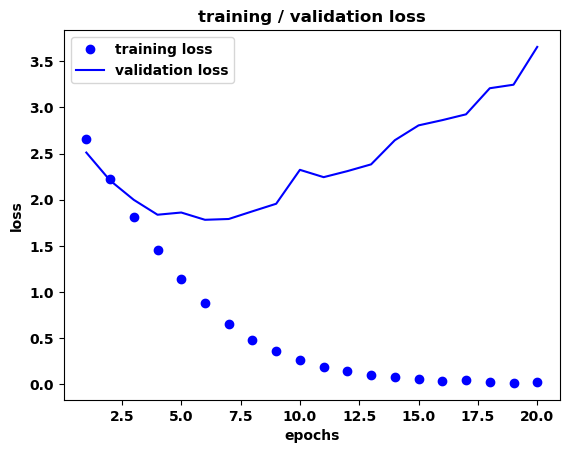

In [27]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training / validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

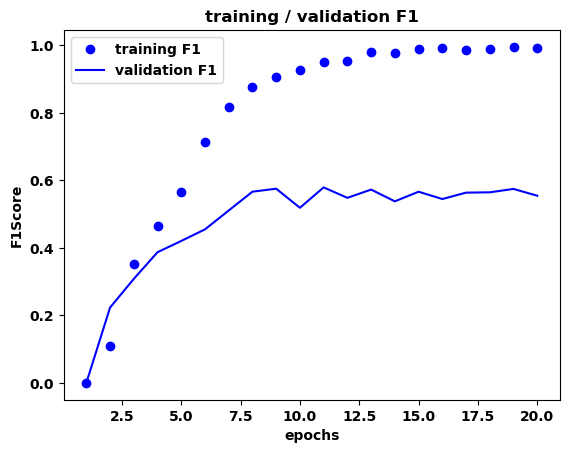

In [28]:
plt.clf()

acc = history.history['custom_f1_score']
val_acc = history.history['val_custom_f1_score']

plt.plot(epochs, acc, 'bo', label='training F1')
plt.plot(epochs, val_acc, 'b', label='validation F1')
plt.title('training / validation F1')
plt.xlabel('epochs')
plt.ylabel('F1Score')
plt.legend()

plt.show()

In [29]:
model.evaluate(test_data, test_labels)

2/2 [==============================] - 0s 5ms/step - loss: 3.9495 - custom_f1_score: 0.5975


[3.9494998455047607, 0.5974602699279785]

In [34]:
predictions = model.predict(one_hot_results)

15/15 [==============================] - 0s 3ms/step


In [55]:
predicted_class = []

for i in range(len(predictions)):
    predicted_class.append(np.argmax(predictions[i]))
    
df_predicted_class = pd.DataFrame({"ann_classification": predicted_class}).merge(label_df, how = "left", left_on = "ann_classification", right_on = "label_code")
df_predicted_class = df_predicted_class[["ann_classification", "class_label"]].rename(columns = {"class_label": "ann_label"})
df_predicted_class

,ann_classification,ann_label
0,10,Sonstiges
1,10,Sonstiges
2,7,Project administration
3,6,Other - not related
4,0,Conceptualization / Conceptualisation
...,...,...
444,10,Sonstiges
445,11,Supervision
446,8,Resources
447,2,Formal analysis


In [56]:
contributions_df_shuffled.join(df_predicted_class)

,contribution,class_label,label_code,ann_classification,ann_label
0,"assisted with NOD mice experiments, NOD mice c...",Sonstiges,10,10,Sonstiges
1,had full access to the data,Sonstiges,10,10,Sonstiges
2,selected drug targets,Project administration,7,7,Project administration
3,Painted a landscape picture,Other - not related,6,6,Other - not related
4,were responsible for conceptualization,Conceptualization / Conceptualisation,0,0,Conceptualization / Conceptualisation
...,...,...,...,...,...
444,for critical discussion on constructing iBKH,Investigation,4,10,Sonstiges
445,provided useful suggestions for the evaluation,Resources,8,11,Supervision
446,approved final version to be published,Supervision,11,8,Resources
447,carried out analysis,Formal analysis,2,2,Formal analysis


## GloVE Approach

Processing Embeddings

In [127]:
import os
glove_dir = './GitHub/glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors' % len(embeddings_index))

Found 400000 word vectors


Now, build an embedding matrix that can be loaded into an `Embedding` layer. It must be a matrix of shape `(max_words,embedding_dim)`, where each entry `i` contains the `embedding_dim`-dimensional vector for the word of index `i` in our reference word index (built during tokenization). Note that the index `0` is not supposed to stand for any word or token. It is simply a placeholder.

In [128]:
max_words = len(word_index) + 1
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in the embedding index will be all-zeros
            embedding_matrix[i] = embedding_vector

In [129]:
len(embedding_matrix)

641

In [130]:
embedding_matrix[1]

array([-0.038194  , -0.24487001,  0.72812003, -0.39961001,  0.083172  ,
        0.043953  , -0.39140999,  0.3344    , -0.57545   ,  0.087459  ,
        0.28786999, -0.06731   ,  0.30906001, -0.26383999, -0.13231   ,
       -0.20757   ,  0.33395001, -0.33848   , -0.31742999, -0.48335999,
        0.1464    , -0.37303999,  0.34577   ,  0.052041  ,  0.44946   ,
       -0.46970999,  0.02628   , -0.54154998, -0.15518001, -0.14106999,
       -0.039722  ,  0.28277001,  0.14393   ,  0.23464   , -0.31020999,
        0.086173  ,  0.20397   ,  0.52623999,  0.17163999, -0.082378  ,
       -0.71787   , -0.41531   ,  0.20334999, -0.12763   ,  0.41367   ,
        0.55186999,  0.57907999, -0.33476999, -0.36559001, -0.54856998,
       -0.062892  ,  0.26583999,  0.30204999,  0.99774998, -0.80480999,
       -3.0243001 ,  0.01254   , -0.36941999,  2.21670008,  0.72201002,
       -0.24978   ,  0.92136002,  0.034514  ,  0.46744999,  1.10790002,
       -0.19358   , -0.074575  ,  0.23353   , -0.052062  , -0.22

**Visualization**

In [62]:
# https://colab.research.google.com/github/cohere-ai/notebooks/blob/main/notebooks/Visualizing_Text_Embeddings.ipynb#scrollTo=Ojnrp5fRqD_r
# Reduce dimensionality using PCA
from sklearn.decomposition import PCA

# Function to return the principal components
def get_pc(arr,n):
  pca = PCA(n_components=n)
  embeds_transform = pca.fit_transform(arr)
  return embeds_transform

# Reduce embeddings to 1 principal component
embeds_pc = get_pc(embedding_matrix,1)

In [99]:
# get reduced word embeddings for one_hot_encoded sentences
sentences_1d_word_embeds = one_hot_results * np.concatenate((embeds_pc.flatten(), np.zeros(359)), axis = None)


# reduce sentences to 2d to for plot
embeds_2d_sentences = get_pc(sentences_1d_word_embeds, 2)
embeds_2d_sentences

array([[ 2.95731380e+00, -7.04724950e-01],
       [ 2.30011983e+00,  2.12778107e+00],
       [-7.10613640e-01, -2.02207700e-01],
       [-1.65418170e+00, -7.15392665e-01],
       [-7.07088610e-01, -1.04924390e+00],
       [-1.68059499e+00, -8.46287461e-01],
       [ 2.06447610e-01,  3.04361536e+00],
       [-7.41414378e-01, -3.23195380e-01],
       [ 4.08650821e-01,  3.01099892e+00],
       [-7.16596863e-01, -2.11895471e-01],
       [-8.50925172e-01, -3.61042554e-01],
       [ 2.73157088e+00, -1.57965519e+00],
       [ 1.78627696e-01,  6.89883548e-02],
       [-7.09263521e-01, -2.00390620e-01],
       [ 2.31175518e+00,  2.10681076e+00],
       [ 2.04306044e+00, -8.49727168e-01],
       [-7.06541065e-01, -2.22143323e-01],
       [-7.09548936e-01, -2.23319821e-01],
       [-7.13220911e-01, -2.10880196e-01],
       [-7.07889923e-01, -2.16177043e-01],
       [ 8.49397255e-01,  2.89185166e-01],
       [-7.82580241e-01, -4.86123252e-01],
       [ 2.02630567e+00, -8.29695796e-01],
       [-7.

In [106]:
contributions_df_shuffled_with_coords = contributions_df_shuffled.join(pd.DataFrame(embeds_2d_sentences).rename(columns = {0: "x_axis", 1: "y_axis"}), how = "left")
contributions_df_shuffled_with_coords

,contribution,class_label,label_code,x_axis,y_axis
0,"assisted with NOD mice experiments, NOD mice c...",Sonstiges,10,2.957314,-0.704725
1,had full access to the data,Sonstiges,10,2.300120,2.127781
2,selected drug targets,Project administration,7,-0.710614,-0.202208
3,Painted a landscape picture,Other - not related,6,-1.654182,-0.715393
4,were responsible for conceptualization,Conceptualization / Conceptualisation,0,-0.707089,-1.049244
...,...,...,...,...,...
444,for critical discussion on constructing iBKH,Investigation,4,-0.695776,-1.142225
445,provided useful suggestions for the evaluation,Resources,8,1.994708,-1.659838
446,approved final version to be published,Supervision,11,-0.359769,2.820258
447,carried out analysis,Formal analysis,2,-0.701521,-0.247941


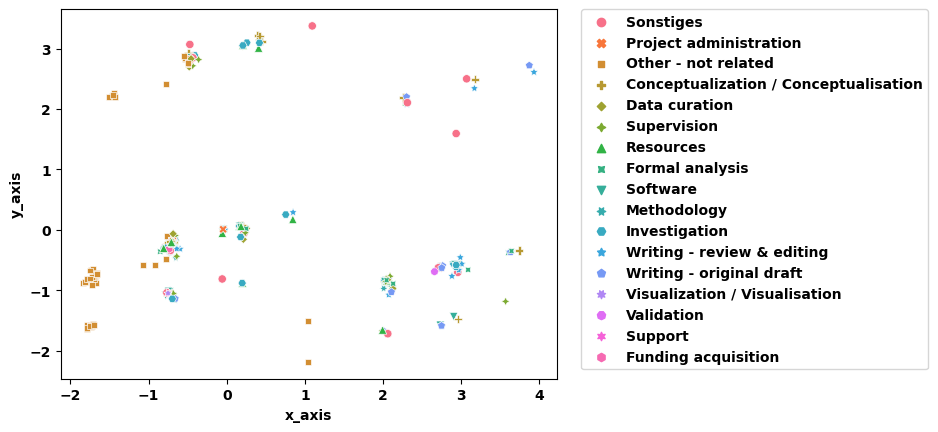

In [118]:
import seaborn as sns
# Use the 'hue' argument to provide a factor variable
sns.scatterplot(x = "x_axis", y = "y_axis", data=contributions_df_shuffled_with_coords, hue="class_label", style = "class_label", markers = True, legend="auto")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

plt.show()

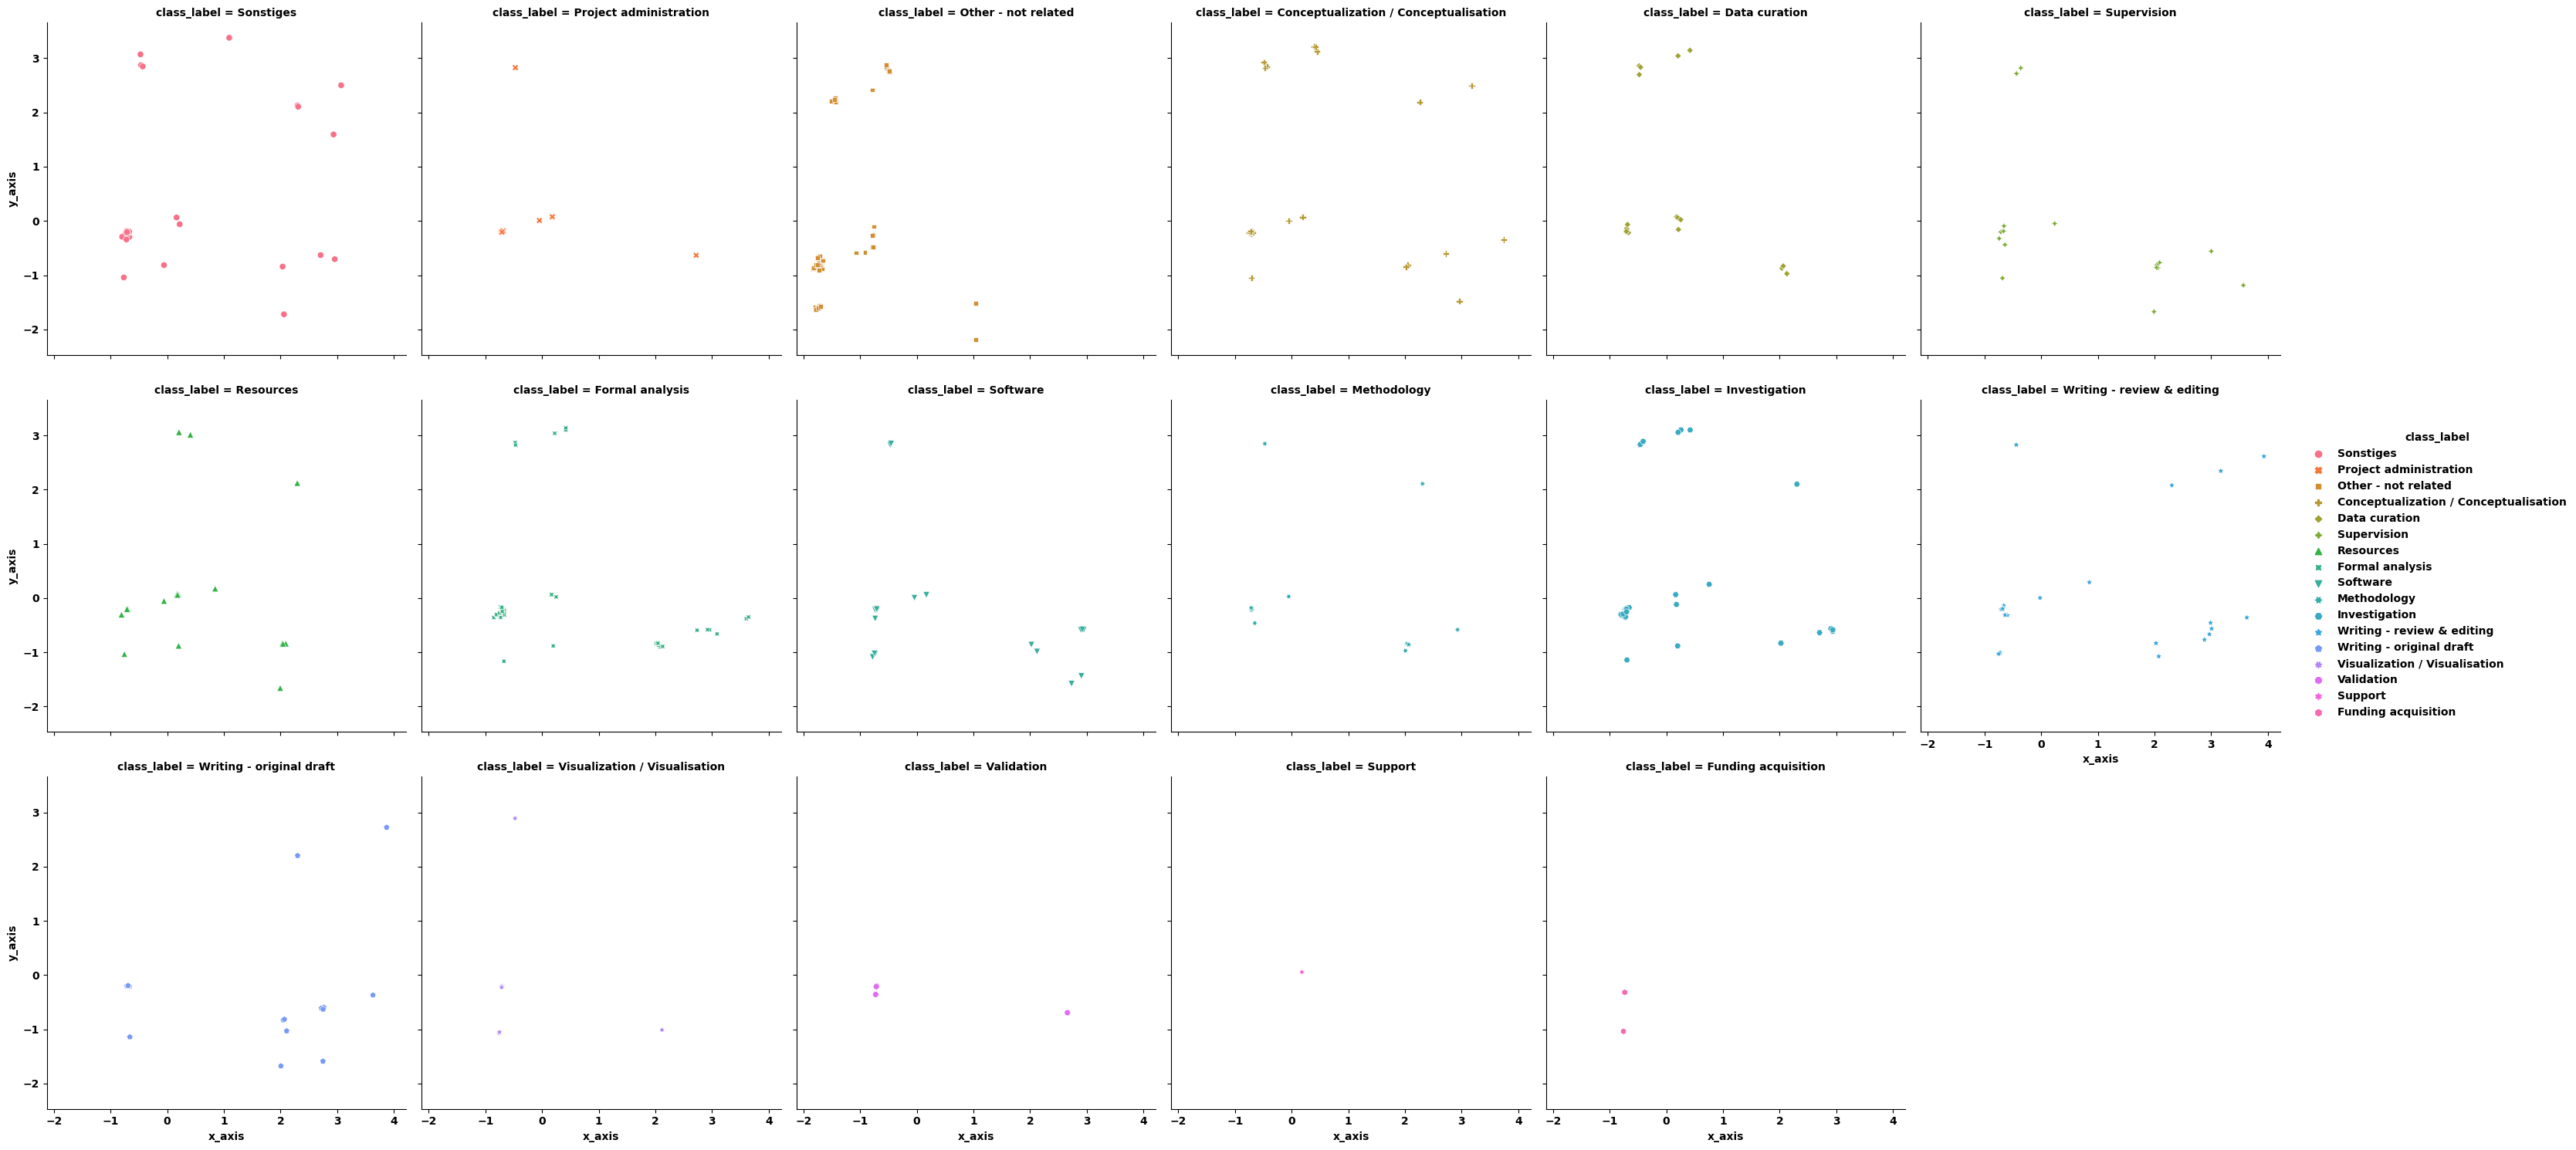

In [173]:
sns.relplot(
    x = "x_axis", y = "y_axis", data=contributions_df_shuffled_with_coords, hue="class_label",
    col="class_label", col_wrap = 6, style="class_label",
    kind="scatter"
)

plt.show()

**Building a model**

In [131]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

maxlen = 1000

glove_model = Sequential()
glove_model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
glove_model.add(Flatten())
glove_model.add(Dense(64, activation='relu'))
glove_model.add(Dense(17, activation='sigmoid'))
glove_model.summary()

glove_model.layers[0].set_weights([embedding_matrix])
glove_model.layers[0].trainable = False

glove_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=[custom_f1_score])

history = glove_model.fit(train_data, train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_data, val_labels))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 100)         64100     
                                                                 
 flatten_1 (Flatten)         (None, 100000)            0         
                                                                 
 dense_20 (Dense)            (None, 64)                6400064   
                                                                 
 dense_21 (Dense)            (None, 17)                1105      
                                                                 
Total params: 6,465,269
Trainable params: 6,465,269
Non-trainable params: 0
_________________________________________________________________


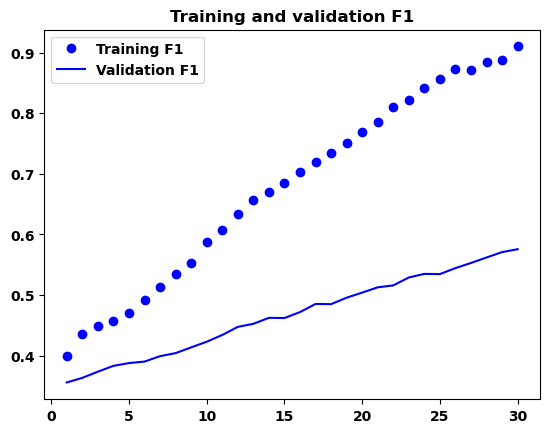

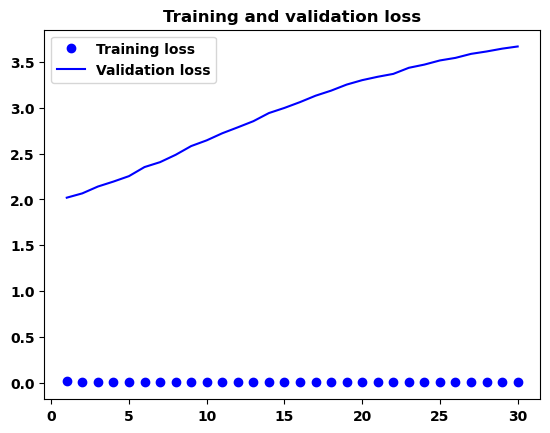

In [136]:
import matplotlib.pyplot as plt

f1 = history.history['custom_f1_score']
val_f1 = history.history['val_custom_f1_score']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(f1) + 1)

plt.plot(epochs, f1, 'bo', label='Training F1')
plt.plot(epochs, val_f1, 'b', label='Validation F1')
plt.title('Training and validation F1')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [137]:
glove_model.evaluate(test_data, test_labels)

2/2 [==============================] - 0s 12ms/step - loss: 3.2848 - custom_f1_score: 0.5917


[3.284787893295288, 0.591651439666748]

The Glove Approach is performing worse than the previous approach, reaching an accuracy of 59,4 % for the test data.

**Get Glove classification**

In [139]:
predictions_glove = glove_model.predict(one_hot_results)
predictions_glove

15/15 [==============================] - 0s 20ms/step


array([[6.0580610e-11, 4.4895287e-10, 8.7465656e-01, ..., 1.3613159e-09,
        5.3521065e-04, 1.1121545e-05],
       [1.2300988e-03, 5.0768174e-02, 3.4817342e-02, ..., 3.8038375e-05,
        1.0436170e-04, 1.9806331e-04],
       [1.0973119e-01, 4.0519591e-02, 1.7312290e-02, ..., 1.8517983e-04,
        2.3327640e-04, 3.9465390e-03],
       ...,
       [3.6680303e-05, 3.2495879e-02, 1.3976769e-03, ..., 8.4432349e-02,
        1.5334568e-04, 9.7355187e-01],
       [5.6648850e-01, 3.8351977e-01, 9.9994242e-01, ..., 1.1770992e-02,
        3.1402757e-04, 2.4855690e-04],
       [1.3416719e-02, 6.3857532e-01, 6.4390257e-02, ..., 5.3685151e-02,
        4.7525313e-02, 2.1297117e-03]], dtype=float32)

In [146]:
predictions_glove = glove_model.predict(one_hot_results)

predicted_class = []

for i in range(len(predictions_glove)):
    predicted_class.append(np.argmax(predictions_glove[i]))
    
df_predicted_glove_class = pd.DataFrame({"glove_classification": predicted_class}).merge(label_df, how = "left", left_on = "glove_classification", right_on = "label_code")
df_predicted_glove_class = df_predicted_glove_class[["glove_classification", "class_label"]].rename(columns = {"class_label": "glove_label"})
df_predicted_glove_class

semi_final_df = contributions_df_shuffled.join(df_predicted_glove_class).join(df_predicted_class)
semi_final_df

15/15 [==============================] - 0s 21ms/step


,contribution,class_label,label_code,glove_classification,glove_label,ann_classification,ann_label
0,"assisted with NOD mice experiments, NOD mice c...",Sonstiges,10,10,Sonstiges,10,Sonstiges
1,had full access to the data,Sonstiges,10,10,Sonstiges,10,Sonstiges
2,selected drug targets,Project administration,7,7,Project administration,7,Project administration
3,Painted a landscape picture,Other - not related,6,6,Other - not related,6,Other - not related
4,were responsible for conceptualization,Conceptualization / Conceptualisation,0,0,Conceptualization / Conceptualisation,0,Conceptualization / Conceptualisation
...,...,...,...,...,...,...,...
444,for critical discussion on constructing iBKH,Investigation,4,16,Writing - review & editing,10,Sonstiges
445,provided useful suggestions for the evaluation,Resources,8,8,Resources,11,Supervision
446,approved final version to be published,Supervision,11,11,Supervision,8,Resources
447,carried out analysis,Formal analysis,2,2,Formal analysis,2,Formal analysis


## Clustering via Embeddings
- Clustering via Embeddings (nearest neighbour)

In [151]:
from sklearn.cluster import KMeans

final_df = semi_final_df

# Cluster the embeddings
kmeans_model = KMeans(n_clusters=17, random_state=0)
classes = kmeans_model.fit_predict(sentences_1d_word_embeds).tolist()
final_df["kmeans_cluster"] = (list(map(str,classes)))

final_df = final_df.merge(contributions_df_shuffled_with_coords)
final_df

C:\Users\Thor\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,contribution,class_label,label_code,glove_classification,glove_label,ann_classification,ann_label,kmeans_cluster,x_axis,y_axis
0,"assisted with NOD mice experiments, NOD mice c...",Sonstiges,10,10,Sonstiges,10,Sonstiges,7,2.957314,-0.704725
1,had full access to the data,Sonstiges,10,10,Sonstiges,10,Sonstiges,15,2.300120,2.127781
2,selected drug targets,Project administration,7,7,Project administration,7,Project administration,1,-0.710614,-0.202208
3,Painted a landscape picture,Other - not related,6,6,Other - not related,6,Other - not related,4,-1.654182,-0.715393
4,were responsible for conceptualization,Conceptualization / Conceptualisation,0,0,Conceptualization / Conceptualisation,0,Conceptualization / Conceptualisation,9,-0.707089,-1.049244
...,...,...,...,...,...,...,...,...,...,...
462,for critical discussion on constructing iBKH,Investigation,4,16,Writing - review & editing,10,Sonstiges,5,-0.695776,-1.142225
463,provided useful suggestions for the evaluation,Resources,8,8,Resources,11,Supervision,14,1.994708,-1.659838
464,approved final version to be published,Supervision,11,11,Supervision,8,Resources,8,-0.359769,2.820258
465,carried out analysis,Formal analysis,2,2,Formal analysis,2,Formal analysis,1,-0.701521,-0.247941


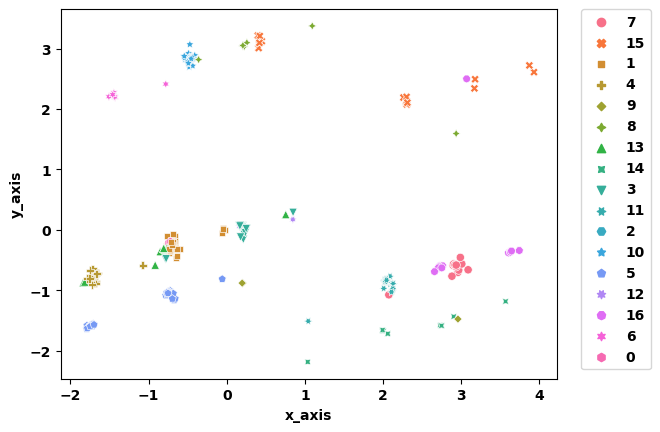

In [152]:
sns.scatterplot(x = "x_axis", y = "y_axis", data=final_df, hue="kmeans_cluster", style = "kmeans_cluster", markers = True, legend="auto")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

plt.show()

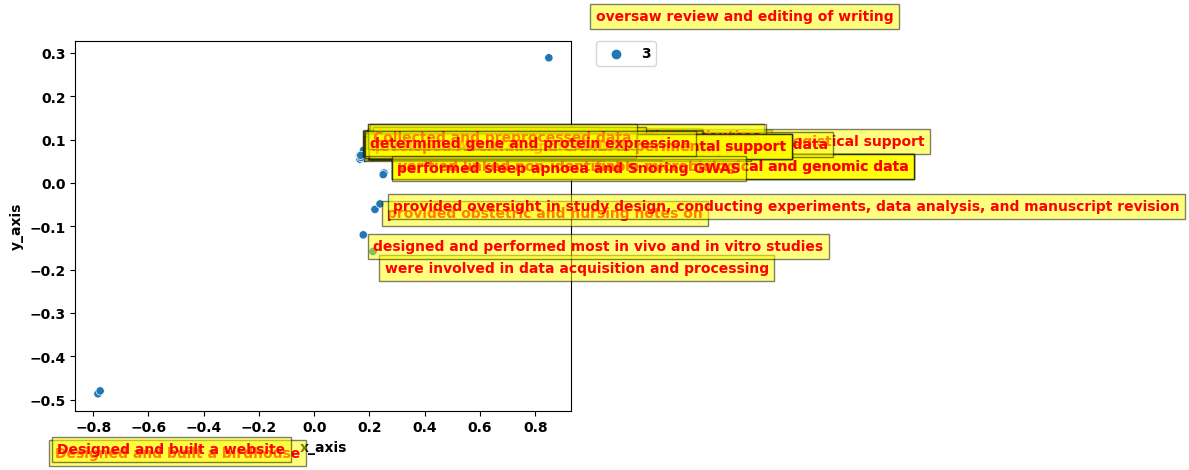

In [171]:
final_df_sub = final_df.loc[final_df.kmeans_cluster == "3"]

sns.scatterplot(x = "x_axis", y = "y_axis", data=final_df_sub, hue="kmeans_cluster", style = "kmeans_cluster", markers = True, legend="auto")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

for i in range(final_df_sub.shape[0]):
 plt.text(x=final_df_sub.x_axis.iloc[i]*1.2,y=final_df_sub.y_axis.iloc[i]*1.3,s=final_df_sub.contribution.iloc[i], 
          fontdict=dict(color="red",size=10),
          bbox=dict(facecolor="yellow",alpha=0.5))

plt.show()

In [181]:
final_df.loc[final_df.label_code == 4][:15]

,contribution,class_label,label_code,glove_classification,glove_label,ann_classification,ann_label,kmeans_cluster,x_axis,y_axis
19,designed survey,Investigation,4,4,Investigation,4,Investigation,1,-0.706541,-0.222143
34,assisted research,Investigation,4,4,Investigation,4,Investigation,1,-0.717104,-0.210610
44,conceived research,Investigation,4,4,Investigation,4,Investigation,1,-0.715540,-0.211602
48,designed & performed NPC experiments,Investigation,4,4,Investigation,4,Investigation,1,-0.710502,-0.237861
50,designed this research,Investigation,4,4,Investigation,4,Investigation,1,-0.733690,-0.210617
52,devised experiments,Investigation,4,4,Investigation,4,Investigation,1,-0.711274,-0.206229
53,contributed to discussion,Investigation,4,4,Investigation,4,Investigation,10,-0.467921,2.822549
57,performed experimental work,Investigation,4,4,Investigation,4,Investigation,1,-0.687527,-0.181761
58,assisted all experiments,Investigation,4,4,Investigation,4,Investigation,1,-0.705481,-0.196454
76,performed research,Investigation,4,4,Investigation,4,Investigation,1,-0.719643,-0.220613


In [182]:
final_df.loc[final_df.label_code == 4][15:30]

,contribution,class_label,label_code,glove_classification,glove_label,ann_classification,ann_label,kmeans_cluster,x_axis,y_axis
175,conducted experiments,Investigation,4,4,Investigation,4,Investigation,1,-0.711077,-0.208099
180,conducted investigations,Investigation,4,4,Investigation,4,Investigation,1,-0.709529,-0.202335
193,discussed the results and implications,Investigation,4,4,Investigation,4,Investigation,7,2.904174,-0.565339
199,provided clincial interpretation,Investigation,4,4,Investigation,4,Investigation,1,-0.700565,-0.206585
200,conducted most of the animal/cell experiments,Investigation,4,4,Investigation,4,Investigation,16,2.703301,-0.637608
217,has contributed to interpretation of results,Investigation,4,4,Investigation,4,Investigation,8,0.258170,3.100601
222,has contributed to interpretation,Investigation,4,4,Investigation,4,Investigation,10,-0.409597,2.889755
234,helped to interpret the pathology,Investigation,4,4,Investigation,4,Investigation,15,2.304380,2.098864
244,assisted with some experiments,Investigation,4,4,Investigation,4,Investigation,13,-0.787299,-0.321299
251,carried out all central tissue immunostaining,Investigation,4,4,Investigation,4,Investigation,1,-0.704383,-0.242084


In [183]:
final_df.loc[final_df.label_code == 4][30:]

,contribution,class_label,label_code,glove_classification,glove_label,ann_classification,ann_label,kmeans_cluster,x_axis,y_axis
304,conceived experiments,Investigation,4,4,Investigation,4,Investigation,1,-0.708417,-0.206731
324,designed and set up the PaNDiv Experiment,Investigation,4,4,Investigation,4,Investigation,7,2.935123,-0.612057
333,assisted in conducting experiments,Investigation,4,4,Investigation,4,Investigation,1,-0.720673,-0.346318
335,conducted the clinical trials,Investigation,4,2,Formal analysis,2,Formal analysis,11,2.020296,-0.832364
346,were responsible for experiments and data anal...,Investigation,4,2,Formal analysis,2,Formal analysis,9,0.198193,-0.882339
381,solved all crystal structures and performed al...,Investigation,4,2,Formal analysis,2,Formal analysis,12,0.164153,0.062543
390,performed experiments,Investigation,4,4,Investigation,4,Investigation,1,-0.712521,-0.215742
393,conceived and designed the resting-state compu...,Investigation,4,4,Investigation,2,Formal analysis,7,2.936403,-0.583704
411,discussed findings,Investigation,4,4,Investigation,4,Investigation,1,-0.704567,-0.202548
416,helped with specific experiments,Investigation,4,4,Investigation,10,Sonstiges,13,-0.762259,-0.294730
